# Rotten Tomatoes: Audience vs Critics

This analysis aims to use data from **Rotten Tomatoes**, a website that offers entertainment reviews and recommendations, to understand differences in movie preferences between critics and regular audience members.

The specific questions the analysis will attempt to address are as follows:

1. Does a significant difference exist in the respective movie rating behaviour of the audience and critics?
2. If so, what are the drivers of said differences?
3. What are the key determinants that influence rating behaviour for each group?

## 1) Gathering the Data

Let's start by importing the libraries necessary for conducting the analysis. We'll first need to wrangle the data set, for which we'll use pandas and NumPy. We'll then build some visualisations using Matplotlib. Finally, we'll use scikit-learn to implement a simple linear model.

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', quality=100)
import dataframe_image as dfi

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

The next step is to read in the data set from a CSV file.  Acknowledgements for the source of the data can be found in the repository's README.

In [2]:
df = pd.read_csv('rotten_tomatoes_movies.csv')

## 2) Assessing the Data

Now that we've read in the data set, let's inspect the columns.

In [3]:
df.columns

Index(['rotten_tomatoes_link', 'movie_title', 'movie_info',
       'critics_consensus', 'content_rating', 'genres', 'directors', 'authors',
       'actors', 'original_release_date', 'streaming_release_date', 'runtime',
       'production_company', 'tomatometer_status', 'tomatometer_rating',
       'tomatometer_count', 'audience_status', 'audience_rating',
       'audience_count', 'tomatometer_top_critics_count',
       'tomatometer_fresh_critics_count', 'tomatometer_rotten_critics_count'],
      dtype='object')

Since only some of these columns will be useful in our analysis, we can streamline the process by selecting only the columns of interest.

In [4]:
cols_of_interest = ['movie_title', 'genres', 'content_rating', 'original_release_date', 'streaming_release_date', \
                    'runtime', 'tomatometer_rating', 'tomatometer_count', 'audience_rating', 'audience_count']
df = df[cols_of_interest]
df.head()

,movie_title,genres,content_rating,original_release_date,streaming_release_date,runtime,tomatometer_rating,tomatometer_count,audience_rating,audience_count
0,Percy Jackson & the Olympians: The Lightning T...,"Action & Adventure, Comedy, Drama, Science Fic...",PG,2010-02-12,2015-11-25,119.0,49.0,149.0,53.0,254421.0
1,Please Give,Comedy,R,2010-04-30,2012-09-04,90.0,87.0,142.0,64.0,11574.0
2,10,"Comedy, Romance",R,1979-10-05,2014-07-24,122.0,67.0,24.0,53.0,14684.0
3,12 Angry Men (Twelve Angry Men),"Classics, Drama",NR,1957-04-13,2017-01-13,95.0,100.0,54.0,97.0,105386.0
4,"20,000 Leagues Under The Sea","Action & Adventure, Drama, Kids & Family",G,1954-01-01,2016-06-10,127.0,89.0,27.0,74.0,68918.0


Let's check the initial number of rows our data set has, and see how many missing values each column contains.

In [5]:
def count_nulls(df):
    """Displays the number of null values present in each column of the dataframe specified."""
    null_counts = df.count().reset_index()
    null_counts.columns = ['col', 'nulls']
    null_counts.nulls = len(df) - null_counts.nulls
    display(null_counts)

print(df.shape)
count_nulls(df)

(17712, 10)


,col,nulls
0,movie_title,0
1,genres,19
2,content_rating,0
3,original_release_date,1166
4,streaming_release_date,384
5,runtime,314
6,tomatometer_rating,44
7,tomatometer_count,44
8,audience_rating,296
9,audience_count,297


## 3) Data Cleaning

We can see that the **original_release_date** column contains more missing values than any other column. Let's apply some domain knowledge to try and clean this up. There must be some rows for which the **original_release_date** is missing, but the **streaming_release_date** is not. This is likely to be instances of movies that were released exclusively on streaming platforms and weren't shown in cinemas. Let's create a holistic **release_date** column by imputing the streaming release into any rows missing the original release.

In [6]:
df.original_release_date.fillna(df.streaming_release_date, inplace=True)
df.drop(columns=['streaming_release_date'], inplace=True)
df.rename(columns={'original_release_date': 'release_date'}, inplace=True)

Since comparing the critic and audience ratings will be the main focus of the analysis, let's filter out any rows for which we don't have rating information from either group.

In [7]:
df = df[(df.tomatometer_count>0) & (df.audience_count>0)]

There could also be cases of movies which, for some reason, appear in the data set more than once. Let's check for any duplicates.

In [8]:
duplicate_counts = df.movie_title.value_counts().reset_index()
duplicate_counts.columns = ['movie_title', 'occurences']
duplicate_counts = duplicate_counts[duplicate_counts.occurences>1]
print('# of Duplicate Rows: ' + str(len(duplicate_counts)))
duplicate_counts.head()

# of Duplicate Rows: 538


,movie_title,occurences
0,Home,5
1,Hamlet,5
2,Carrie,4
3,Little Women,4
4,Alice in Wonderland,4


Before simply dropping duplicates within the **movie_title** column, let's once again apply some domain knowledge. There could feasibly be instances of two different movies having the same title, such as if an older movie was remade at some point in the future. However, it's unlikely that two movies with the same title and release year aren't the result of an error in the data set. Let's use these two columns to remove duplicates.

In [9]:
df.drop_duplicates(subset=['movie_title', 'release_date'], inplace=True)

Let's check the data set's missing value counts again now that we've taken some steps to clean it up.

In [10]:
print(df.shape)
count_nulls(df)

(17406, 9)


,col,nulls
0,movie_title,0
1,genres,19
2,content_rating,0
3,release_date,96
4,runtime,238
5,tomatometer_rating,0
6,tomatometer_count,0
7,audience_rating,0
8,audience_count,0


We now have only three columns that contain missing values: **genres**, **release_date**, and **runtime**.

Since the **runtime** is a numerical value, we can easily impute the missing values at a point later in the analysis.

The **genres** and **release_date** columns offer less opportunity for imputation. However, there are also relatively small numbers of missing values in these columns, so we can drop the missing rows without losing a significant amount of information.

In [11]:
df.dropna(subset=['genres', 'release_date'], inplace=True)

For ease of use, let's sort the data set by the **release_date** column, and then run a final check of the remaining number of rows in the data set and counts of missing values.

In [12]:
df = df.sort_values(by='release_date', ascending=True).reset_index(drop=True)

In [13]:
print(df.shape)
count_nulls(df)

(17291, 9)


,col,nulls
0,movie_title,0
1,genres,0
2,content_rating,0
3,release_date,0
4,runtime,159
5,tomatometer_rating,0
6,tomatometer_count,0
7,audience_rating,0
8,audience_count,0


Great! We've dealt with all of the missing values where necessary and only lost around **2%** of the initial data set in the process. Let's take a look at the first few rows of our newly-cleaned data set.

In [14]:
df.head()

,movie_title,genres,content_rating,release_date,runtime,tomatometer_rating,tomatometer_count,audience_rating,audience_count
0,Cabiria,"Art House & International, Classics, Drama",NR,1914-06-01,123.0,96.0,26.0,69.0,1155.0
1,A Fool There Was,"Classics, Drama",NR,1915-01-01,60.0,83.0,6.0,53.0,1220.0
2,The Birth of a Nation,"Classics, Drama",G,1915-03-03,190.0,93.0,44.0,56.0,4804.0
3,Intolerance,Classics,PG,1916-09-05,178.0,97.0,37.0,77.0,4908.0
4,Broken Blossoms,"Classics, Drama, Romance",NR,1919-05-13,87.0,95.0,22.0,71.0,3802.0


There's a possibility that some of the movies in our data set may have received much fewer ratings than others from either the critics or the audience, which could lead to an unreliable average rating and therefore inaccurate results. Let's apply a statistical approach to determining whether there are any outliers in either the **tomatometer_count** or **audience_count** columns.

We're only interested in outliers that don't meet the lower bound, since those that surpass the upper bound would indicate that a movie has received many more ratings than the others, and thus wouldn't be considered unreliable.

In [15]:
def get_outliers(df, col):
    """Prints the number of outliers that fall below the lower bound of the column specified."""
    iqr = np.percentile(df[col], 75) - np.percentile(df[col], 25)
    lower_bound = np.median(df[col]) - (1.5*iqr)
    outliers = len(df[df[col] < lower_bound])
    print('# Outliers: ' + str(outliers))
    print('Lower Bound: ' + str(lower_bound))

In [16]:
print('Critics')
get_outliers(df, 'tomatometer_count')
print('-'*20)
print('Audience')
get_outliers(df, 'audience_count')

Critics
# Outliers: 0
Lower Bound: -68.5
--------------------
Audience
# Outliers: 0
Lower Bound: -32663.5


According to this approach, there aren't any statistical outliers in either of the count columns, so we can proceed without dropping any further rows.

## 4) Analysis and Visualisation
### Part I: Assessing the extent of audience/critic differences

Now that we have clean data to work with, let's start the analysis by broadly comparing the rating behaviour of the critics and audience. We can first use a **histogram** to look at a simple distribution of the two groups' ratings.

In [17]:
critic_color = 'steelblue'
audience_color = 'lightblue'

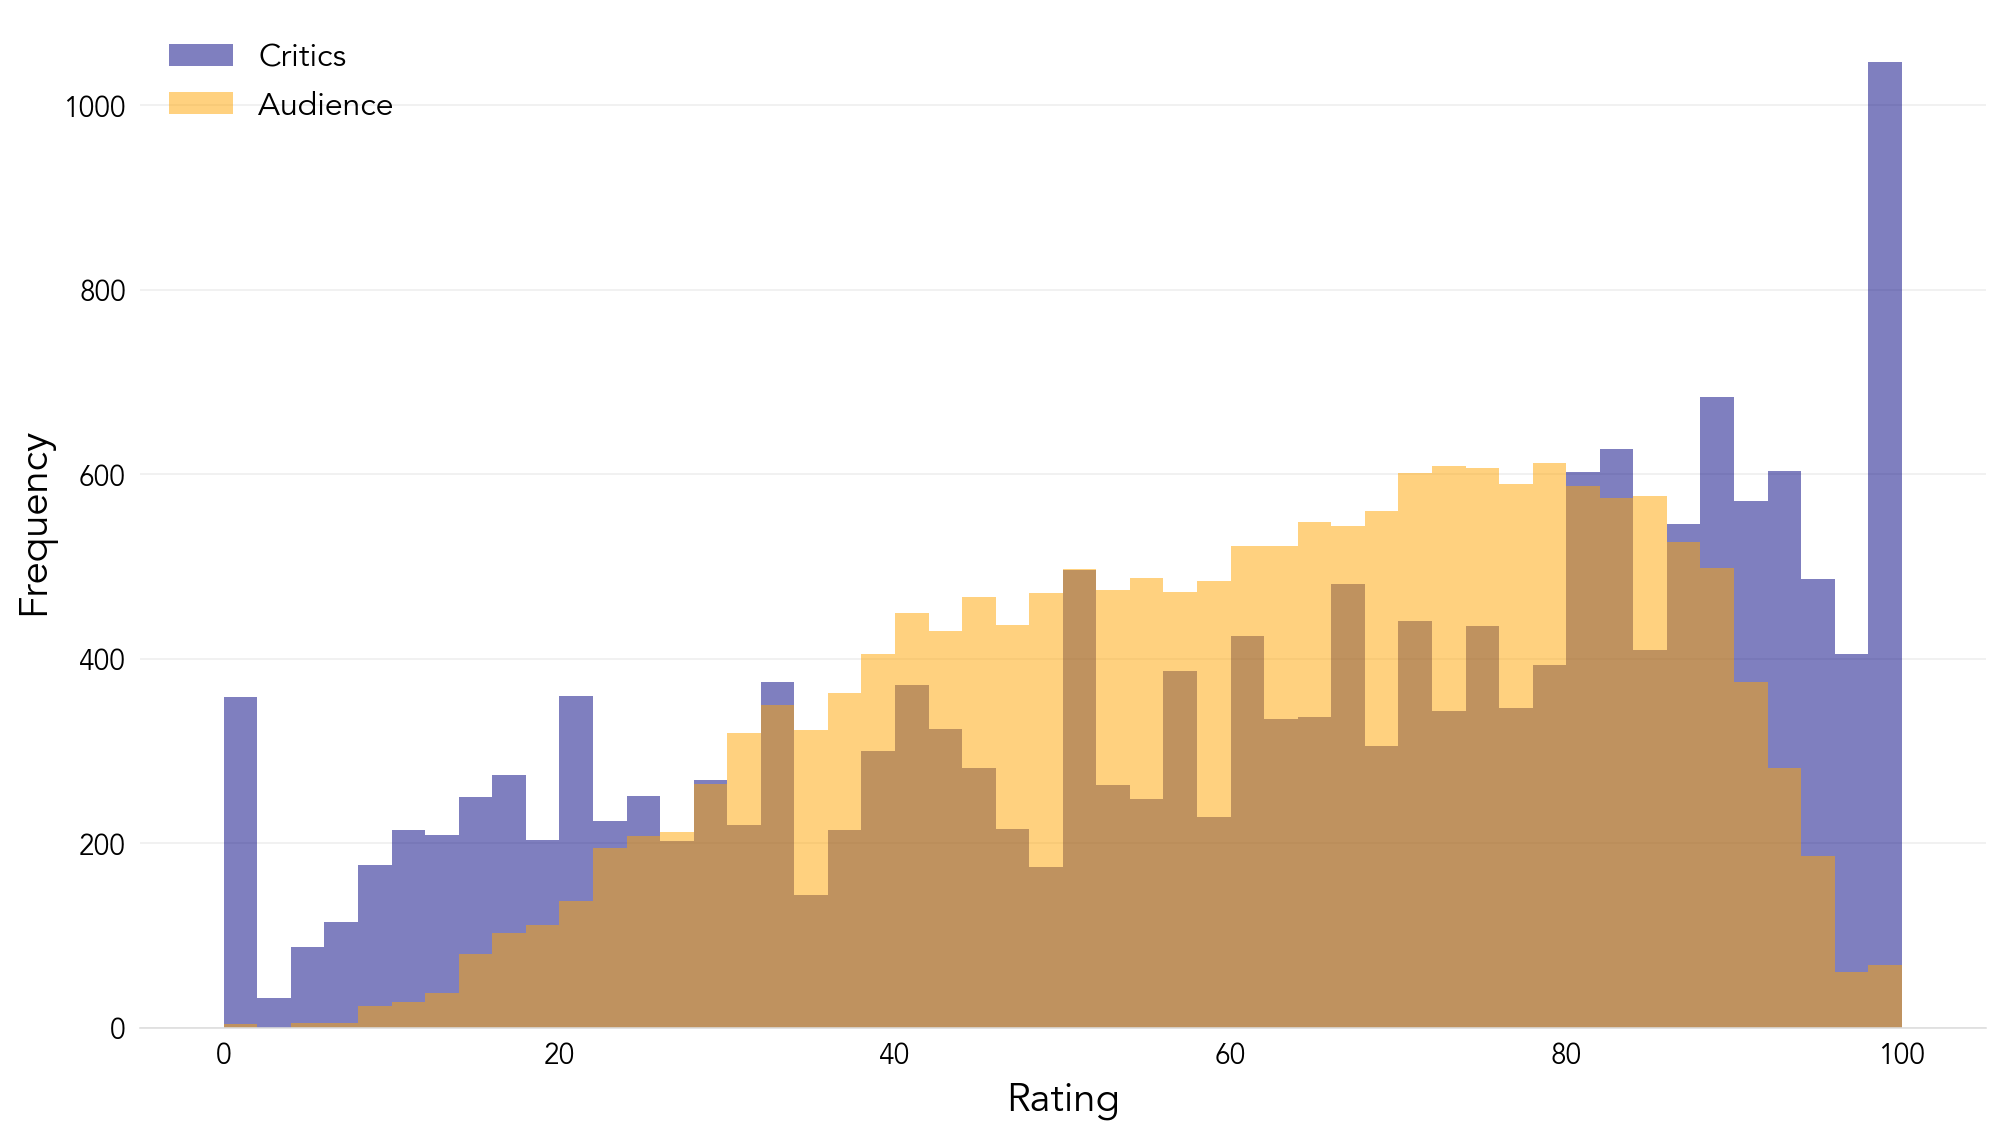

In [18]:
fig1 = plt.figure(figsize=(14, 8))
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Avenir'
ax = fig1.add_subplot(1, 1, 1)
ax.hist(df.tomatometer_rating, color='navy', alpha=0.5, bins=50)
ax.hist(df.audience_rating, color='orange', alpha=0.5, bins=50)

ax.set_xlabel('Rating', fontsize=20)
ax.set_ylabel('Frequency', fontsize=20)
ax.set_xticks(range(0, 101, 20))
ax.set_xticklabels(range(0, 101, 20), fontsize=14)
ax.set_yticks(range(0, 1001, 200))
ax.set_yticklabels(range(0, 1001, 200), fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

ax.legend(labels=['Critics', 'Audience'], fontsize=16, framealpha=0)

plt.tight_layout()
plt.show()
fig1.savefig('rating_distribution.png')

Next, let's use a **scatter plot** to assess whether there's any obvious correlation between the two groups' ratings, with each point on the plot representing an individual movie.

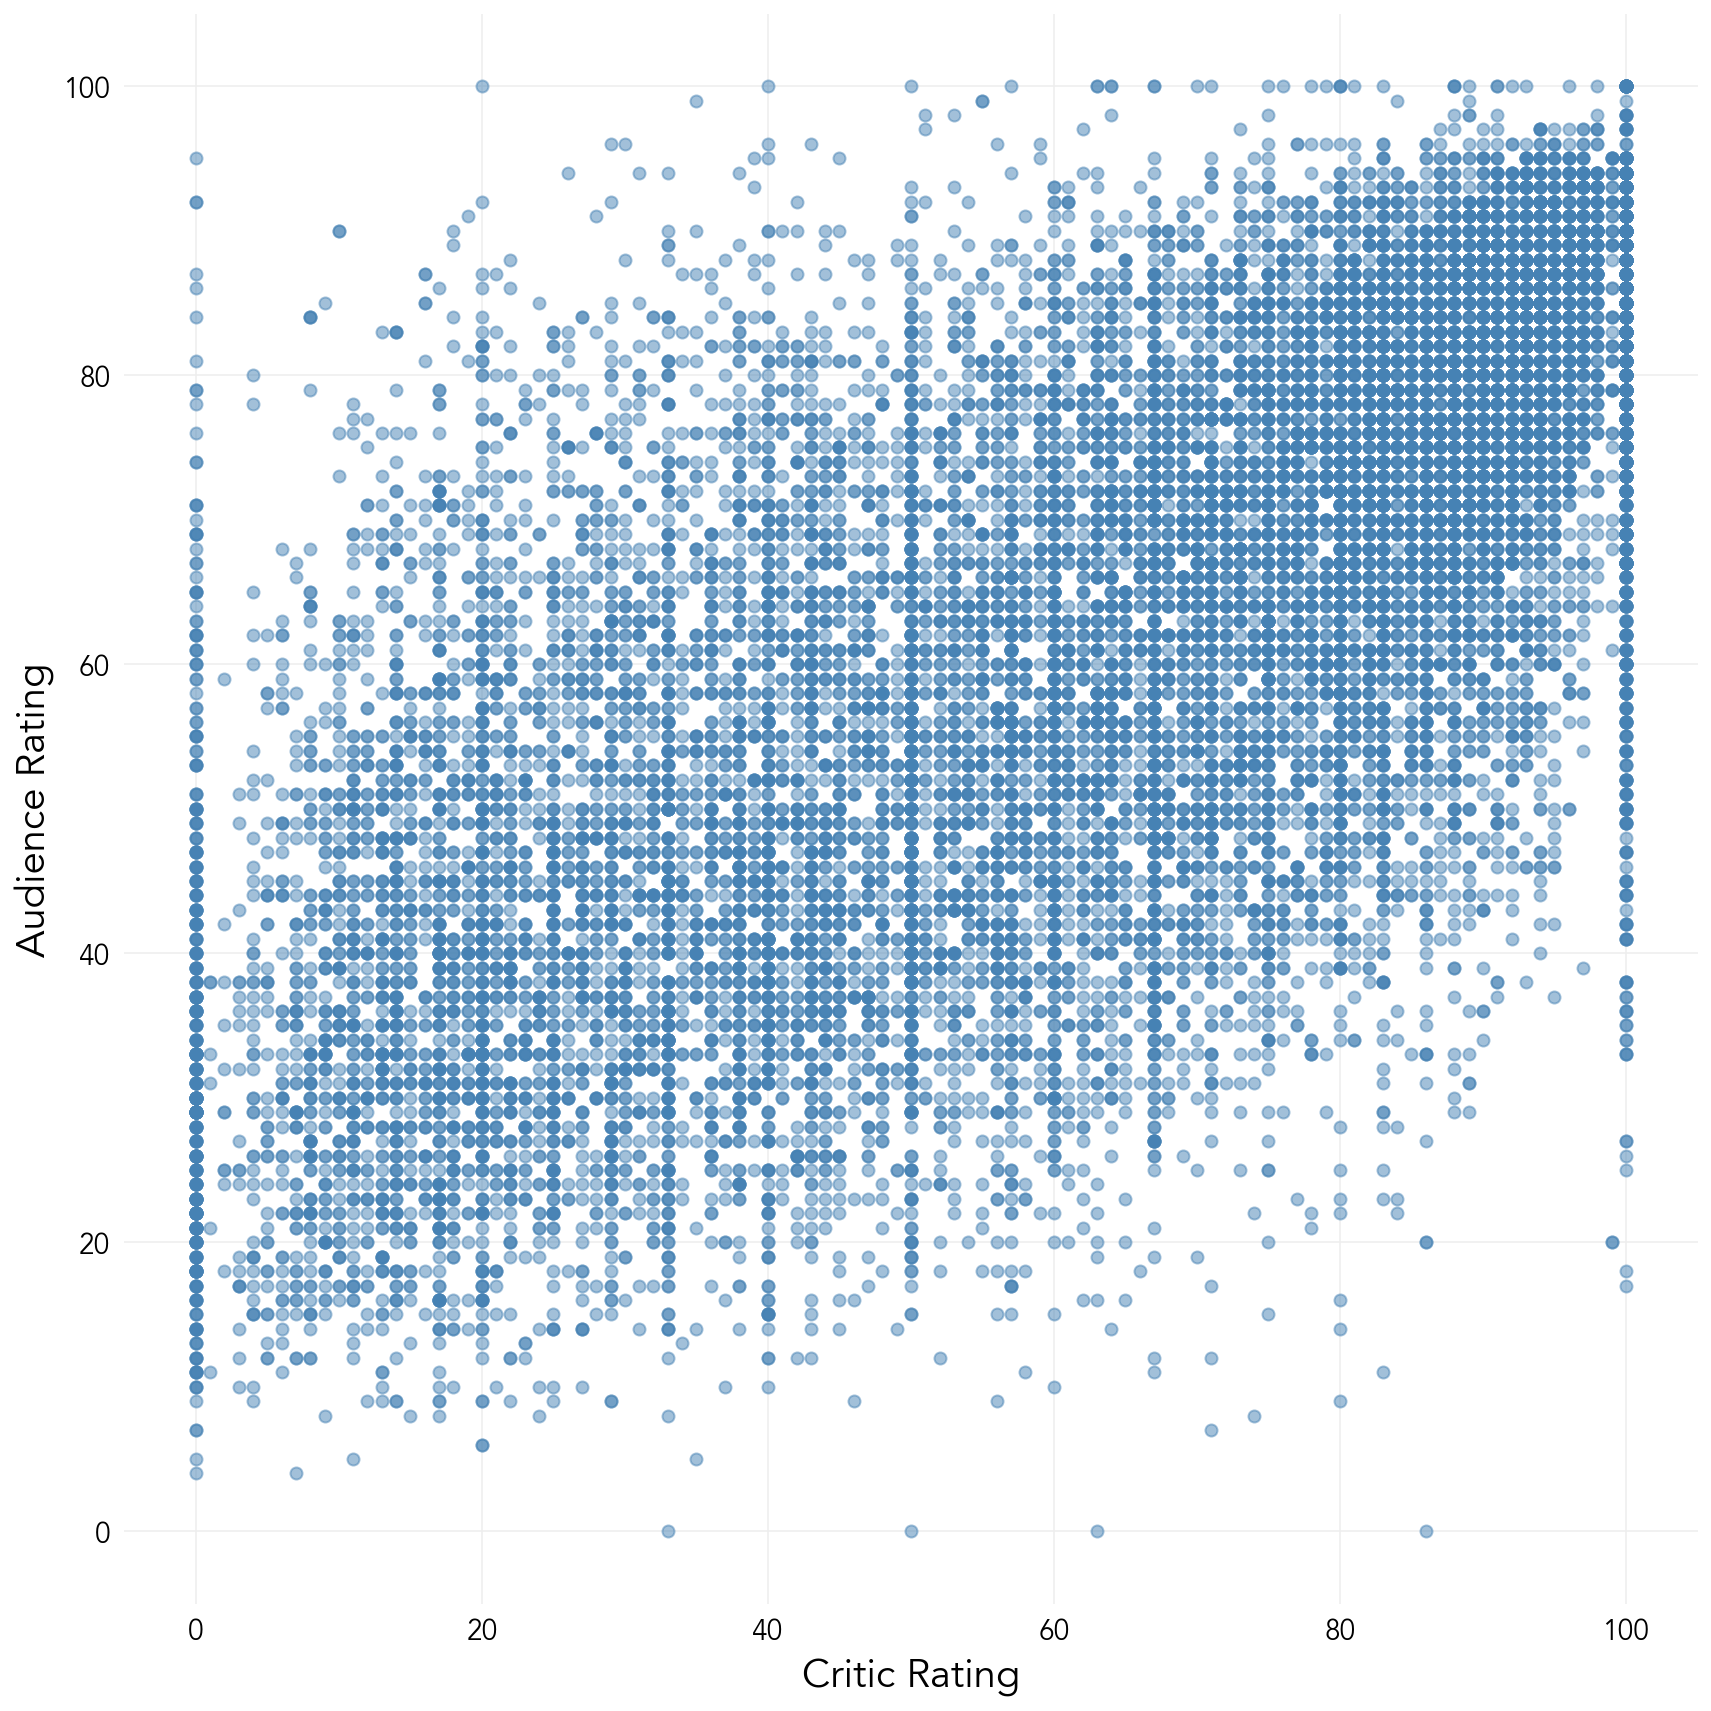

In [19]:
fig2 = plt.figure(figsize=(12, 12))
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Avenir'
ax = fig2.add_subplot(1, 1, 1)
ax.scatter(df.tomatometer_rating, df.audience_rating, color='steelblue', alpha=0.5)

ax.set_xlabel('Critic Rating', fontsize=20)
ax.set_ylabel('Audience Rating', fontsize=20)
ax.set_xticks(range(0, 101, 20))
ax.set_xticklabels(range(0, 101, 20), fontsize=14)
ax.set_yticks(range(0, 101, 20))
ax.set_yticklabels(range(0, 101, 20), fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(True, color='#EEEEEE')

plt.tight_layout()
plt.show()
fig2.savefig('rating_correlation.png')

### Part II: Analysing the drivers of differences in behaviour

As the first step in a deep dive into the drivers of differences between the two groups' ratings, let's focus on the **genres** column.

We can see above that each movie can be assigned multiple genres, all of which are listed as strings separated by commas. Keeping the column in this format will make aggregating the data difficult, since it will likely contain an overly large number of unique values.

To solve this, for each movie, let's split each of its genres into a separate row. This means that, for example, a movie with three different genres will appear three times. This will then allow us to find the average rating for the critics and audience respectively per individual genre.

In [20]:
genre_compare = df[['genres', 'tomatometer_rating', 'audience_rating']]
critic_stack = pd.DataFrame(df.genres.str.split(',').tolist(), index=df.tomatometer_rating).stack()
critic_stack = critic_stack.reset_index()[[0, 'tomatometer_rating']]
audience_stack = pd.DataFrame(df.genres.str.split(',').tolist(), index=df.audience_rating).stack()
audience_stack = audience_stack.reset_index()[[0, 'audience_rating']]
genre_compare = pd.concat([critic_stack, audience_stack[['audience_rating']]], axis=1)
genre_compare.rename(columns={0: 'genre'}, inplace=True)
genre_compare.genre = genre_compare.genre.str.lstrip()
genre_compare = genre_compare.groupby('genre').mean().reset_index()
genre_compare['abs_delta'] = abs(genre_compare.tomatometer_rating - genre_compare.audience_rating)
genre_compare.head()

,genre,tomatometer_rating,audience_rating,abs_delta
0,Action & Adventure,54.149801,57.863843,3.714042
1,Animation,63.982287,65.681159,1.698873
2,Anime & Manga,75.368421,75.000000,0.368421
3,Art House & International,70.999190,66.525932,4.473258
4,Classics,78.371429,71.040122,7.331307


Now that we've found the average rating per genre per group, let's take a look at the genres with the largest differences between groups, and also those that are the most similar. Finally, let's visualise the information in a **grouped bar chart**.

In [21]:
print('Most Different')
display(genre_compare.sort_values(by='abs_delta', ascending=False).head(10))
print('-'*50)
print('Most Similar')
display(genre_compare.sort_values(by='abs_delta', ascending=True).head(10))

Most Different


,genre,tomatometer_rating,audience_rating,abs_delta
7,Documentary,80.838826,73.238414,7.600412
4,Classics,78.371429,71.040122,7.331307
9,Faith & Spirituality,63.886076,70.341772,6.455696
17,Special Interest,77.631841,71.937811,5.694030
11,Horror,51.555556,46.357639,5.197917
19,Television,71.686275,66.611765,5.074510
12,Kids & Family,55.593665,60.266968,4.673303
6,Cult Movies,60.490385,55.846154,4.644231
3,Art House & International,70.999190,66.525932,4.473258
10,Gay & Lesbian,57.605263,61.486842,3.881579


--------------------------------------------------
Most Similar


,genre,tomatometer_rating,audience_rating,abs_delta
13,Musical & Performing Arts,70.725971,70.834356,0.108384
8,Drama,63.228717,63.090658,0.138059
2,Anime & Manga,75.368421,75.000000,0.368421
16,Science Fiction & Fantasy,55.815761,56.697826,0.882065
14,Mystery & Suspense,55.312034,54.009169,1.302865
1,Animation,63.982287,65.681159,1.698873
18,Sports & Fitness,70.965714,73.382857,2.417143
15,Romance,60.461701,63.407818,2.946117
5,Comedy,54.826448,58.296049,3.469601
0,Action & Adventure,54.149801,57.863843,3.714042


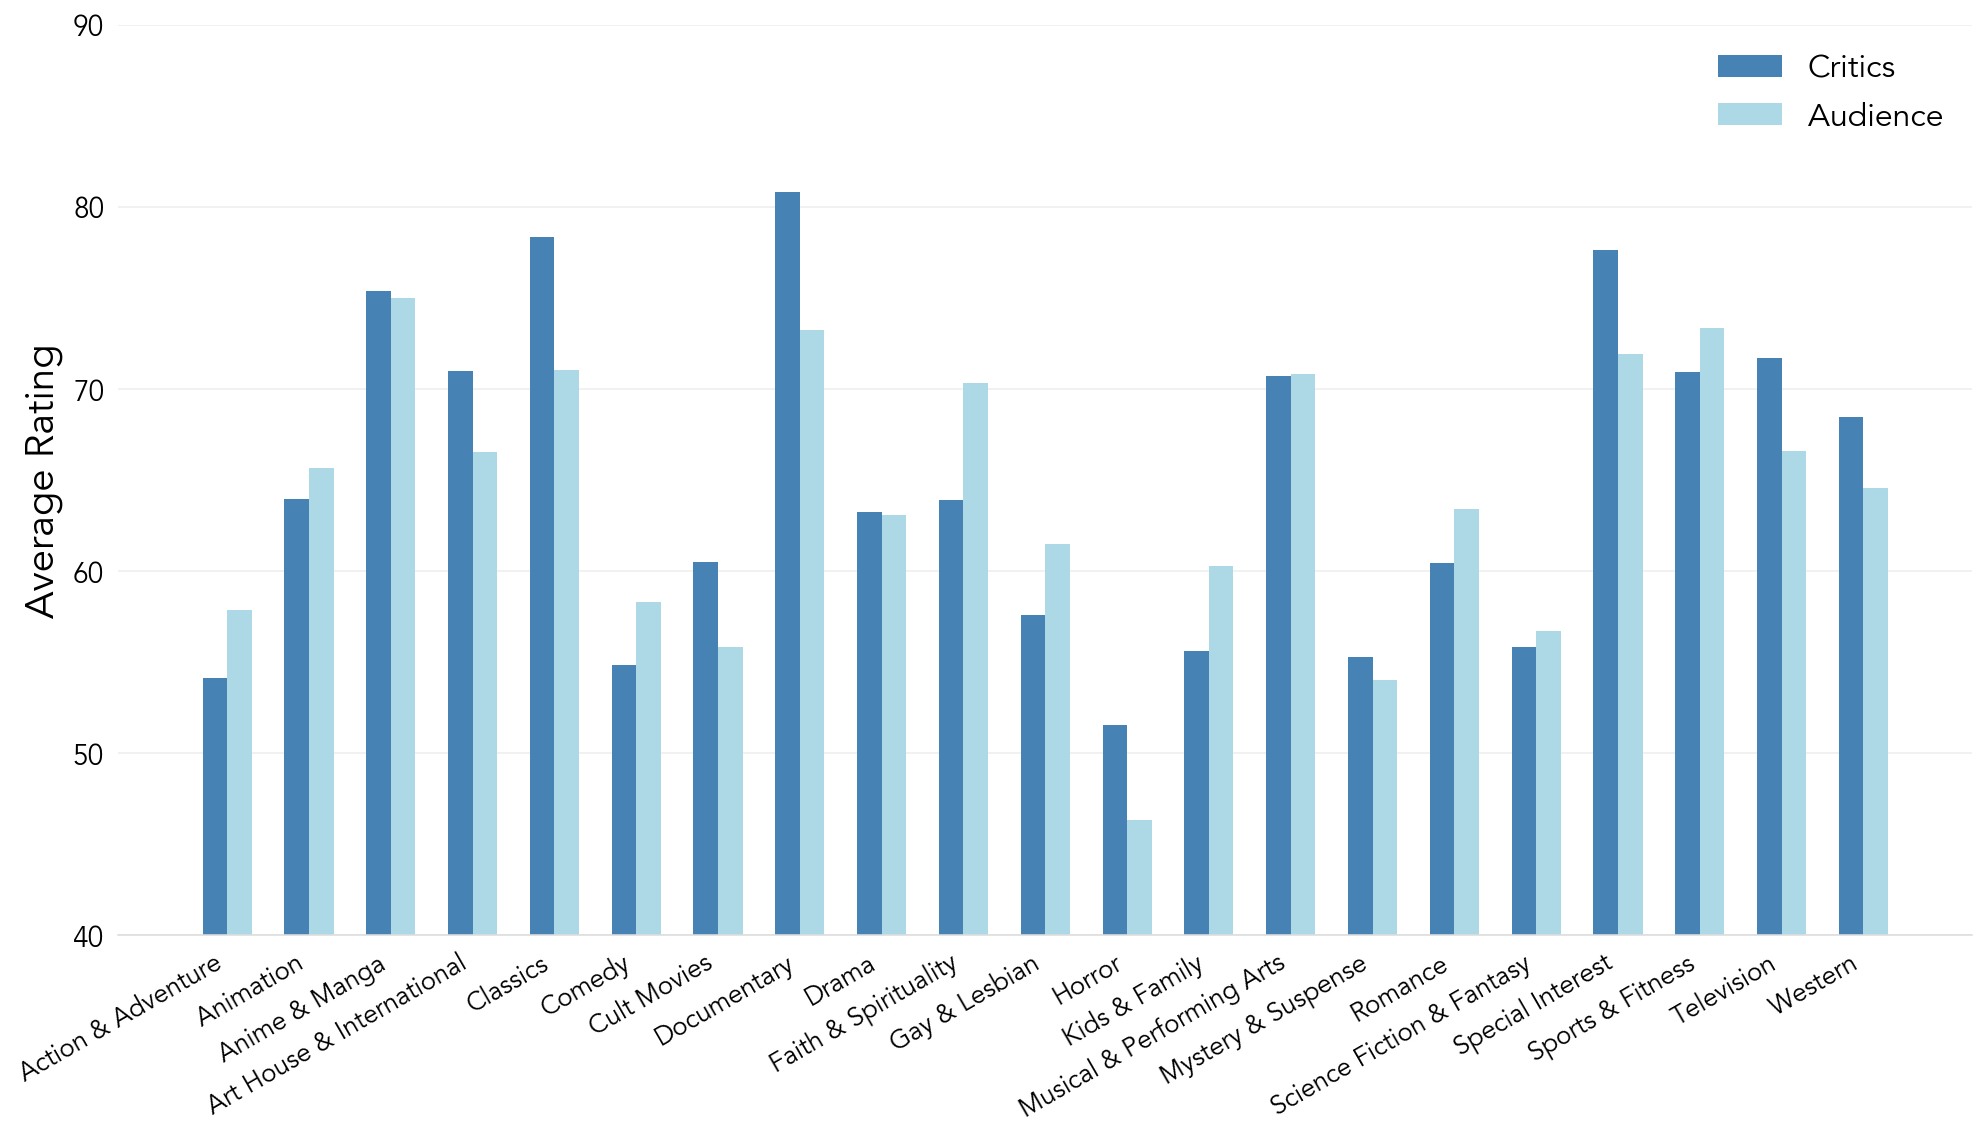

In [22]:
fig3 = plt.figure(figsize=(14, 8))
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Avenir'
ax = fig3.add_subplot(1, 1, 1)

width = 0.3
x1 = [x - width/2 for x in np.arange(len(genre_compare))]
x2 = [x + width/2 for x in np.arange(len(genre_compare))]
ax.bar(x1, genre_compare.tomatometer_rating, width=width, color=critic_color)
ax.bar(x2, genre_compare.audience_rating, width=width, color=audience_color)
ax.set_ylim(40, 90)

ax.set_ylabel('Average Rating', fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)
ax.set_xticks(range(len(genre_compare)))
ax.set_xticklabels(genre_compare.genre, rotation=30, ha='right', fontsize=13)
ax.set_yticks(range(40, 91, 10))
ax.set_yticklabels(range(40, 91, 10), fontsize=14)

ax.legend(labels=['Critics', 'Audience'], fontsize=16, framealpha=0)

plt.tight_layout()
plt.show()
fig3.savefig('genre_compare.png')

The next step we can take to compare tendencies in the respective groups' ratings is to incorporate the **release_date** column. We probably don't need to be specific enough to use the full date, so let's format the column to include only the year in which each movie was released.

In [23]:
df.release_date = df.release_date.apply(lambda x: str(x)[:4])
df.release_date = df.release_date.astype('int64')

We can now undertake a similar aggregation as we did for the genres, and find the average rating per group per release year. Let's start from the year 1920.

Let's also find the count of movies per release year contained in our data set, as this may also provide some useful insights.

In [24]:
date_compare = df[['release_date', 'tomatometer_rating', 'audience_rating']].sort_values(by='release_date', \
                                                                            ascending=True)
date_compare = date_compare.groupby('release_date').mean().reset_index()
date_compare = date_compare[date_compare.release_date>=1920].reset_index(drop=True)
date_compare.head()

,release_date,tomatometer_rating,audience_rating
0,1920,85.166667,73.833333
1,1921,96.000000,83.000000
2,1922,98.200000,77.400000
3,1923,92.000000,81.000000
4,1924,93.000000,86.857143


In [25]:
date_count = df.groupby('release_date').movie_title.count().reset_index()
date_count = date_count[date_count.release_date>=1920].reset_index(drop=True)
date_count.head()

,release_date,movie_title
0,1920,6
1,1921,2
2,1922,5
3,1923,5
4,1924,7


Now let's visualise how each group's average rating has changed over time, and include a plot for the number of movies included in the data set per year.

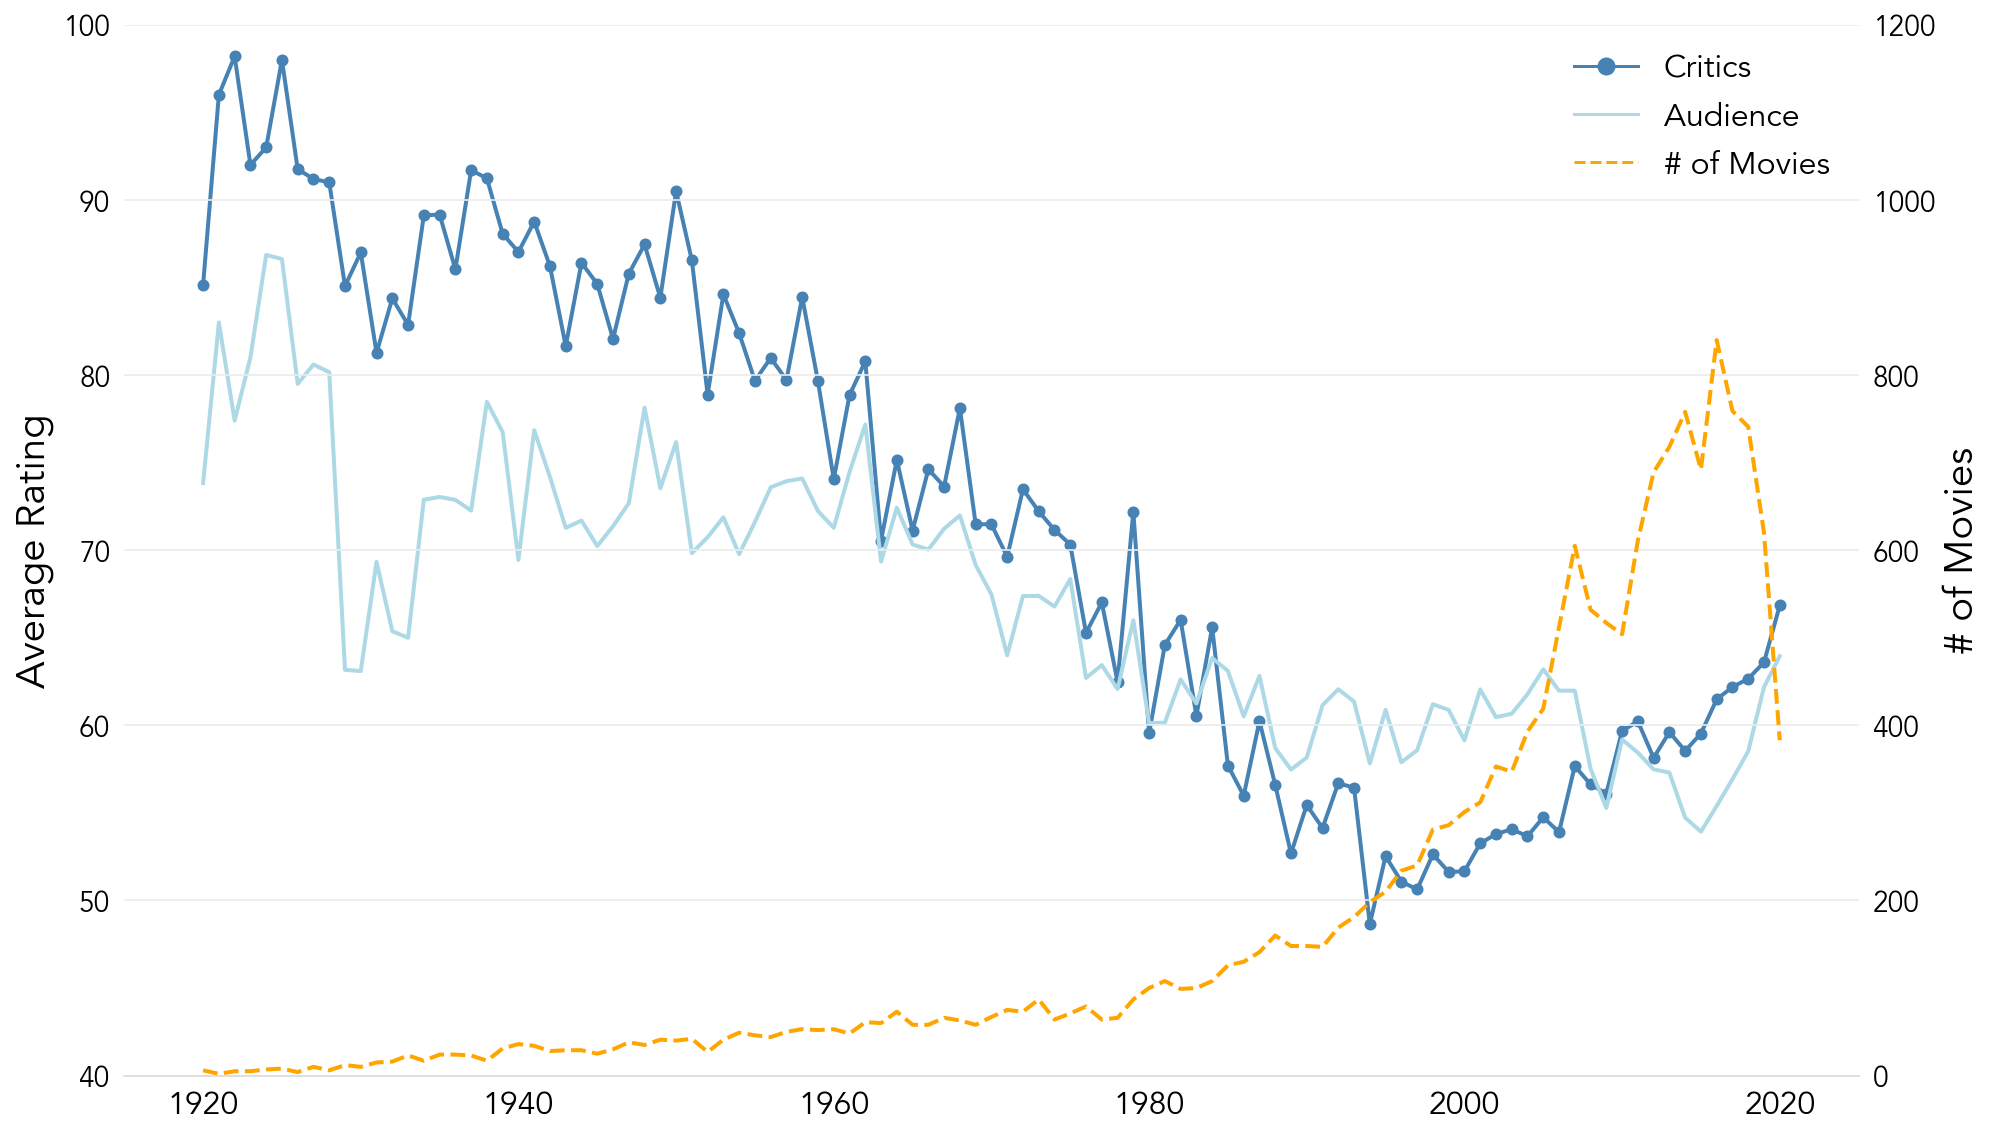

In [26]:
fig4 = plt.figure(figsize=(14, 8))
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Avenir'
ax = fig4.add_subplot(1, 1, 1)
ax2 = ax.twinx()

ax.plot(range(len(date_compare)), date_compare.tomatometer_rating, color=critic_color, marker='o', markersize=5, \
        linewidth=2)
ax.plot(range(len(date_compare)), date_compare.audience_rating, color=audience_color, linewidth=2)
ax2.plot(range(len(date_count)), date_count.movie_title, color='orange', linestyle='--', linewidth=2)

ax.set_ylim(40, 100)
ax.set_ylabel('Average Rating', fontsize=20)
ax.set_yticks(range(40, 101, 10))
ax.set_yticklabels(range(40, 101, 10), fontsize=14)
ax2.set_ylim(0, 300)
ax2.set_ylabel('# of Movies', fontsize=20)
ax2.set_yticks(range(0, 1201, 200))
ax2.set_yticklabels(range(0, 1201, 200), fontsize=14)

for ax in [ax, ax2]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('#DDDDDD')
    ax.tick_params(bottom=False, left=False, right=False)
    ax.set_axisbelow(True)
    ax.yaxis.grid(True, color='#EEEEEE')
    ax.xaxis.grid(False)
    ax.set_xticks(range(0, len(date_compare)+1, 20))
    ax.set_xticklabels(range(date_compare.release_date.min(), date_compare.release_date.max()+1, 20), fontsize=16)

handle1 = Line2D([2], [0], marker='o', color=critic_color, markerfacecolor=critic_color, markersize=8)
handle2 = Line2D([2], [0], color=audience_color)
handle3 = Line2D([2], [0], color='orange', linestyle='--')
ax.legend(handles=[handle1, handle2, handle3], labels=['Critics', 'Audience', '# of Movies'], fontsize=16, \
          framealpha=0)

plt.tight_layout()
plt.show()
fig4.savefig('date_compare.png')

## 5) Modelling
### Part III: Identifying the key determinants of rating behaviour

For the final part of the analysis, let's attempt to identify the main determinants of the two group's respective rating behaviour by implementing a **linear regression model**.

Since scikit-learn's modules are only able to fit models on data sets that don't contain missing values, we'll first need to deal with the nulls in the **runtime** column.

Since this feature of the data set is numerical, we can impute estimates into the missing rows based on the existing data. Let's use the average runtime per release year for the imputation.

In [27]:
runtime_imputer = df.groupby('release_date').runtime.mean().reset_index()
runtime_imputer.rename(columns={'runtime': 'avg_runtime'}, inplace=True)
df = df.merge(runtime_imputer, on='release_date', how='left')
df.runtime.fillna(df.avg_runtime, inplace=True)
df.drop(columns=['avg_runtime'], inplace=True)
df.head()

,movie_title,genres,content_rating,release_date,runtime,tomatometer_rating,tomatometer_count,audience_rating,audience_count
0,Cabiria,"Art House & International, Classics, Drama",NR,1914,123.0,96.0,26.0,69.0,1155.0
1,A Fool There Was,"Classics, Drama",NR,1915,60.0,83.0,6.0,53.0,1220.0
2,The Birth of a Nation,"Classics, Drama",G,1915,190.0,93.0,44.0,56.0,4804.0
3,Intolerance,Classics,PG,1916,178.0,97.0,37.0,77.0,4908.0
4,Broken Blossoms,"Classics, Drama, Romance",NR,1919,87.0,95.0,22.0,71.0,3802.0


For the sake of interpretability of the model's results, let's convert the **release_year** column to an **age** column by subtracting the release year from the current year.

In [28]:
df['age'] = 2021 - df.release_date

Another caveat to using scikit-learn is that data on which models are fit must be passed in in numerical form. Our data set currently includes two categorical columns which could act as useful features in the model: **content_rating** and **genres**. Both of these will need to be dealt with before we construct the model.

Regarding the **content_rating** column, we can apply domain knowledge to deduce that this is essentially a scalar variable, in that the individual values increase in severity of rating. Below we can see the unique values contained in the column. Following a bit of research, we can undertake label encoding by mapping five of these values to a scale from 0 to 4.

Notice that this leaves one categorical value intact: **NR**. This stands for "not rated" and can hence be treated as a missing value. To control for this, let's simply impute the mean value of the column following the label encoding.

The **genres** column must be handled slightly differently. This column's values don't operate on any kind of scale. For example, there's no way to quantitatively compare "Action" with "Romance". To deal with this column, let's instead employ one-hot encoding. This involves creating a new column for each of the individual genres to act as a boolean variable (in the binary 0/1 format) to indicate whether the **genres** column contains the given value.

In [29]:
df.content_rating.unique()

array(['NR', 'G', 'PG', 'R', 'PG-13', 'NC17'], dtype=object)

In [30]:
df.content_rating = df.content_rating.map({'G': 0, 'PG': 1, 'PG-13': 2, 'R': 3, 'NC17': 4})
df.content_rating.fillna(df.content_rating.mean(), inplace=True)

In [31]:
genres = list(genre_compare.genre.unique())
for genre in genres:
    df[genre] = df.genres.apply(lambda x: 1 if genre in x else 0)
df.head()

,movie_title,genres,content_rating,release_date,runtime,tomatometer_rating,tomatometer_count,audience_rating,audience_count,age,...,Horror,Kids & Family,Musical & Performing Arts,Mystery & Suspense,Romance,Science Fiction & Fantasy,Special Interest,Sports & Fitness,Television,Western
0,Cabiria,"Art House & International, Classics, Drama",2.238748,1914,123.0,96.0,26.0,69.0,1155.0,107,...,0,0,0,0,0,0,0,0,0,0
1,A Fool There Was,"Classics, Drama",2.238748,1915,60.0,83.0,6.0,53.0,1220.0,106,...,0,0,0,0,0,0,0,0,0,0
2,The Birth of a Nation,"Classics, Drama",0.000000,1915,190.0,93.0,44.0,56.0,4804.0,106,...,0,0,0,0,0,0,0,0,0,0
3,Intolerance,Classics,1.000000,1916,178.0,97.0,37.0,77.0,4908.0,105,...,0,0,0,0,0,0,0,0,0,0
4,Broken Blossoms,"Classics, Drama, Romance",2.238748,1919,87.0,95.0,22.0,71.0,3802.0,102,...,0,0,0,0,1,0,0,0,0,0


Let's run a final check to make sure our data set is now ready to be modelled.

In [32]:
print(df.shape)
count_nulls(df)

(17291, 31)


,col,nulls
0,movie_title,0
1,genres,0
2,content_rating,0
3,release_date,0
4,runtime,0
5,tomatometer_rating,0
6,tomatometer_count,0
7,audience_rating,0
8,audience_count,0
9,age,0


We can now commence with building the linear model. We first need to split the data into a vector of **features** and a **response variable**.

The **features** (the model's X values) will be the runtime, age, content rating and encoded genre columns.

Since the focus of this part of the analysis is to compare the audience with the critics, we'll need to define two **response variables** (one for each group) and model the data twice. These will be the data set's two rating columns.

In [33]:
X = df[['runtime', 'age', 'content_rating'] + genres]
critic_y = df.tomatometer_rating
audience_y = df.audience_rating

In [34]:
X.head()

,runtime,age,content_rating,Action & Adventure,Animation,Anime & Manga,Art House & International,Classics,Comedy,Cult Movies,...,Horror,Kids & Family,Musical & Performing Arts,Mystery & Suspense,Romance,Science Fiction & Fantasy,Special Interest,Sports & Fitness,Television,Western
0,123.0,107,2.238748,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,60.0,106,2.238748,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,190.0,106,0.000000,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,178.0,105,1.000000,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,87.0,102,2.238748,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


Since the purpose of this model isn't to make predictions, there's no need to split the data into training and testing sets. With that in mind, the data is now ready to be modelled. Let's fit each of the two response variables to the features vector and check the **R^2 scores** to see how well the models fit the data. Because the various columns are significantly different in scale, we'll employ scikit-learn's inbuilt **normalize** function to scale the vector of features.

In [35]:
critic_model = LinearRegression(normalize=True)
critic_model.fit(X, critic_y)
r2_score(critic_y, critic_model.predict(X))

0.20714886315238779

In [36]:
audience_model = LinearRegression(normalize=True)
audience_model.fit(X, audience_y)
r2_score(audience_y, audience_model.predict(X))

0.25226477987262064

Neither of the two models produce a brilliant R^2 score (probably due to the relatively small number of features), but they should nevertheless be sufficient to provide some interesting insights.

The motivation behind implementing a linear model with this data set was to assess both how each feature affects each group's rating behaviour, and which do so the most significantly. This will require us to inspect the models' **coefficients**. To do so, let's build a dataframe to house the coefficients of each group's model and add some bars to visualise the coefficients' directions and magnitudes.

In [37]:
def get_coefs(model, X):
    """Creates a dataframe containing the coefficients of each of the given features in the model specified."""
    coefs_df = pd.DataFrame()
    coefs_df['Feature'] = X.columns
    coefs_df['Coefficient'] = model.coef_
    coefs_df = coefs_df.sort_values(by='Feature', ascending=True).reset_index(drop=True)
    return coefs_df

In [38]:
critic_df = get_coefs(critic_model, X)

In [39]:
audience_df = get_coefs(audience_model, X)

In [40]:
final_coef_df = critic_df.merge(audience_df, on='Feature', how='left')
final_coef_df.columns = ['Feature', 'Critic Coef', 'Audience Coef']
final_coef_df = final_coef_df.style.bar(subset=['Critic Coef', 'Audience Coef'], align='mid', \
                                        color=['#d65f5f', '#5fba7d'])
dfi.export(final_coef_df, 'coefficients.png')
final_coef_df

,Feature,Critic Coef,Audience Coef
0,Action & Adventure,-7.10083,-3.18468
1,Animation,15.6296,12.8931
2,Anime & Manga,3.2738,5.64923
3,Art House & International,10.9763,5.31562
4,Classics,10.9992,1.37718
5,Comedy,-4.37513,-1.25356
6,Cult Movies,0.218756,-0.945893
7,Documentary,27.9064,17.7158
8,Drama,6.08535,4.47451
9,Faith & Spirituality,-12.1529,-1.88823


## 6) Evaluating the Results

If you're interested in reading an interpretation and discussion of the results of this analysis, please feel free to visit the post linked in the repository's README.